# Food Classifier

### In this project we will be using CNN models to predict the food in images.

For this subset, we'll be using "bar food" which includes 3 classes.

## Importing libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

# https://www.linkedin.com/pulse/obtaining-different-results-when-rerunning-identical-neural-boire/
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model, clone_model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add,
                                     Input, BatchNormalization, GlobalAvgPool2D)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input


from PIL import Image

import matplotlib.pyplot as plt
import os

## Reading in the data

In [2]:
# creating variables we will use several times throughout this notebook
# image size we want to resize to
img_size = 256
img_size_tup = (256, 256)

In [3]:
# pulling our data in from directory and preprocessing it

img_path = "./part_01/food-11/images/bar_food"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=(img_size, img_size),
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='training',
          interpolation='bilinear',
          follow_links=True,
          crop_to_aspect_ratio=True
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [4]:
# pulling in our validation data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=(img_size, img_size),
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='validation',
          interpolation='bilinear',
          follow_links=True,
          crop_to_aspect_ratio=True
)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [5]:
# taking a look at our train_data variable
train_data

<BatchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [6]:
# creating a variable of our class names for labeling

class_names = test_data.class_names

# creating a variable of number of classes
n_classes = len(class_names)
n_classes, class_names

(3, ['chicken_wings', 'french_fries', 'onion_rings'])

In [7]:
# creating a function to create our X and y variables in numpy arrays

def preprocess_img_input(batch_dataset):
    for images, labels in batch_dataset.take(1):  # only take first element of dataset
        X = images.numpy()
        y = labels.numpy()

        # rescaling our X data to between 0-1
        X /= 255

        return X, y

In [8]:
# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
X_train, y_train = preprocess_img_input(train_data)
X_test, y_test = preprocess_img_input(test_data)

In [9]:
# checking the shape of X_train and y_train
print(X_train.shape, y_train.shape)

(32, 256, 256, 3) (32, 3)


In [10]:
# checking our pixel sizes
X_train[0][0][0]

array([0.61960787, 0.58431375, 0.6039216 ], dtype=float32)

In [11]:
# checking our pixel sizes for the entire X_train variable
X_train.min(), X_train.max()

(0.0, 1.0)

In [12]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape
input_shape

(256, 256, 3)

## Visualizing our data

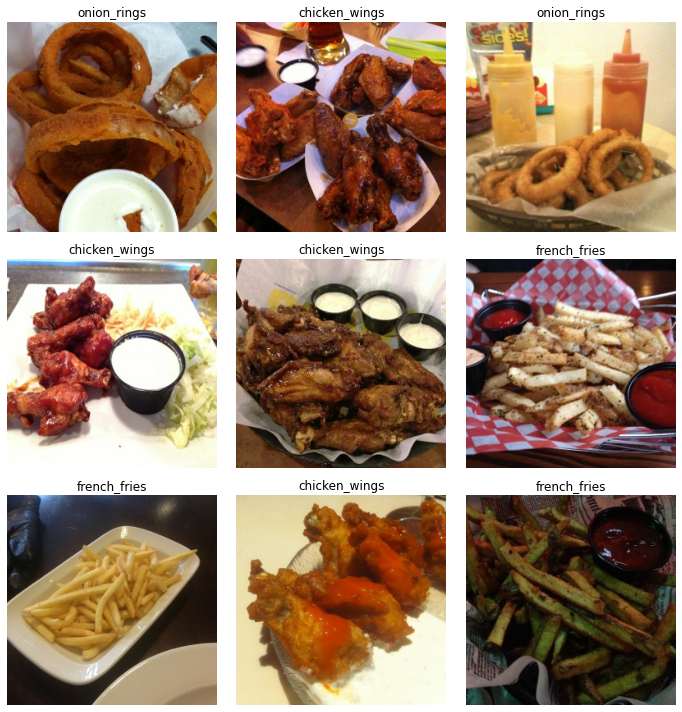

In [13]:
# code help from https://www.tensorflow.org/tutorials/images/classification
# visualizing our data
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[tf.argmax(y_train[i], axis=0)]) ## thanks to: https://stackoverflow.com/questions/41399481/how-do-you-decode-one-hot-labels-in-tensorflow
    plt.axis("off")
    plt.tight_layout()

## Modeling with Neural Nets

In [14]:
# instantiating our model
model = Sequential()
# flattening our data
model.add(Flatten(input_shape=(img_size, img_size, 3)))
# adding dense layers
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
# adding our final dense layer with our n_classes
model.add(Dense(n_classes, activation='softmax'))
# compiling our model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])
# adding an early stop callback
early_stop = EarlyStopping(patience = 15)

# fitting and running our model
results = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=200, batch_size=32, callbacks=early_stop, verbose=1)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.2480 - accuracy: 0.3438 - val_loss: 1.1452 - val_accuracy: 0.4375
Epoch 2/200
1/1 [==============================] - 0s 306ms/step - loss: 1.1949 - accuracy: 0.3750 - val_loss: 1.0826 - val_accuracy: 0.3438
Epoch 3/200
1/1 [==============================] - 0s 286ms/step - loss: 0.9933 - accuracy: 0.5312 - val_loss: 1.1502 - val_accuracy: 0.3125
Epoch 4/200
1/1 [==============================] - 0s 272ms/step - loss: 0.9822 - accuracy: 0.5312 - val_loss: 1.0962 - val_accuracy: 0.3438
Epoch 5/200
1/1 [==============================] - 0s 351ms/step - loss: 0.9027 - accuracy: 0.6562 - val_loss: 1.0472 - val_accuracy: 0.3750
Epoch 6/200
1/1 [==============================] - 0s 312ms/step - loss: 0.8231 - accuracy: 0.9062 - val_loss: 1.0397 - val_accuracy: 0.4688
Epoch 7/200
1/1 [==============================] - 0s 340ms/step - loss: 0.7554 - accuracy: 0.7812 - val_loss: 1.0510 - val_accuracy: 0.4688
Epoch 8/200
1/1 

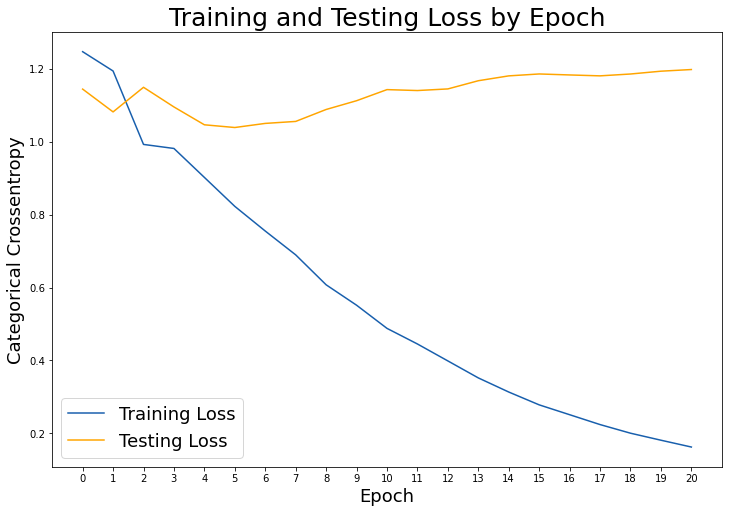

In [15]:
# plotting our models loss over epochs
train_loss = results.history['loss']
test_loss = results.history['val_loss']
epoch_labels = results.epoch

# setting figure size
plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# setting title and labels
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

# adding a legend
plt.legend(fontsize=18);

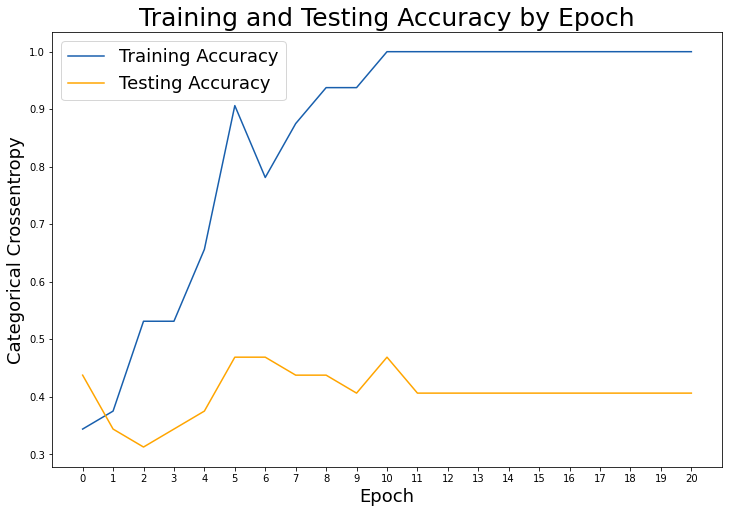

In [16]:
# plotting our models accuracy over epochs
train_acc = results.history['accuracy']
test_acc = results.history['val_accuracy']
epoch_labels = results.epoch

# setting figure size
plt.figure(figsize=(12, 8))

plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# setting title and labels
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

# adding a legend
plt.legend(fontsize=18);

In [17]:
# Evaluating model on test data
score = model.evaluate(X_test, y_test, verbose=1)

labels = model.metrics_names

# displaying scores
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

1/1 [==============================] - 0s 61ms/step - loss: 1.1990 - accuracy: 0.4062
FFNN loss : 1.1989508867263794
FFNN accuracy  : 0.40625


In [18]:
# saving model weights

model.save('FFNN_model_barfood.h5')

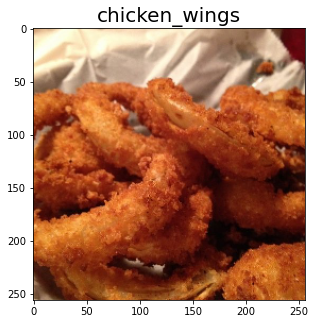

In [19]:
# predicting on one single image
img_path_single = "./part_01/food-11/images/bar_food/onion_rings/1008652.jpg"
# visualizing one prediction
plt.figure(figsize=(5,5))

# loading the image and preprocessing it for the model to predict it
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

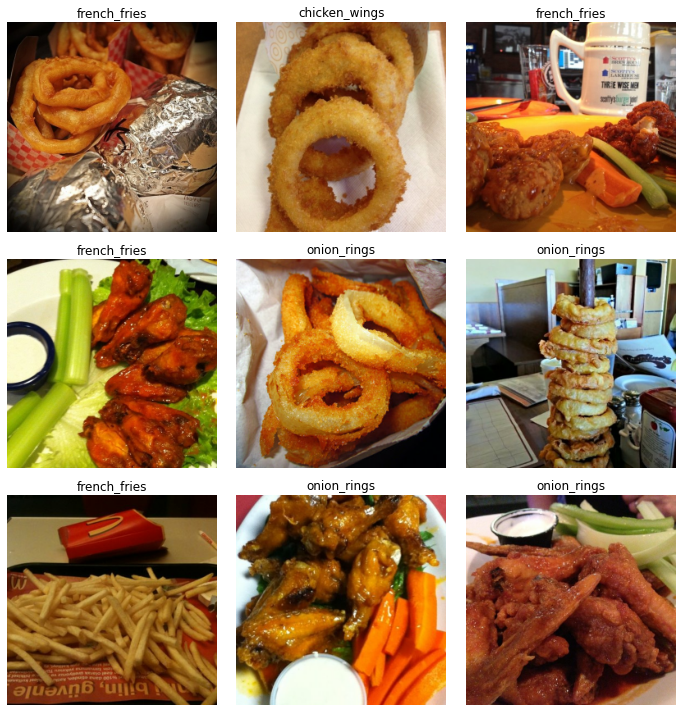

In [20]:
# visualizing a batch of images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

### ** Interpretation **

Our model is very overfit with our training at 100% accuracy and our validation accuracy at 43.75%. Below we will try using a CNN to model the same data.

## Modeling with Convolutional Neural Nets

In [21]:
# Instantiating CNN model
# code from lesson 8.03
cnn_model = Sequential()

# adding convolutional and pooling filter layers
# these layers will create filters over each image to detect edges and shapes
# conv layer 1
cnn_model.add(Conv2D(filters=6, # number of filters
                     kernel_size=(5,5), # height/width of filter
                     activation='relu', # activation function
                     data_format='channels_last',
                     input_shape=(input_shape)))

cnn_model.add(MaxPooling2D(pool_size=(2, 2), padding='same')) # dimensions of region of pooling

# conv layer 2
cnn_model.add(Conv2D(filters=8,
                     kernel_size=(3,3),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 3
cnn_model.add(Conv2D(filters=8,
                     kernel_size=(3,3),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# conv layer 4
# cnn_model.add(Conv2D(filters=6,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 5
# cnn_model.add(Conv2D(filters=6,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 6
# cnn_model.add(Conv2D(filters=12,
#                      kernel_size=(4,4),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 7
# cnn_model.add(Conv2D(filters=16,
#                      kernel_size=(5,5),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# # conv layer 8
# cnn_model.add(SeparableConv2D(filters=6,
#                      kernel_size=(3,3),
#                      activation='relu'))

# cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


# flattening layers
cnn_model.add(Flatten())
# adding dense layers
cnn_model.add(Dense(256, activation='relu'))
# adding dropout to minimize overfitting
# cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))

cnn_model.add(Dense(64, activation='relu'))

cnn_model.add(Dense(32, activation='relu'))

# final layer with number of classes as output
cnn_model.add(Dense(n_classes, activation='softmax'))

# compiling model with optimizer Adam and measuring for accuracy
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.2),
                  metrics=['accuracy'])

# adding an early stop callback to end the model early if it starts to decline
early_stop = EarlyStopping(patience = 10)

# fitting and running the model
cnn_results = cnn_model.fit(X_train,y_train,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            epochs=40,
                            callbacks=early_stop,
                            verbose=1,
                            workers=4)

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0963 - accuracy: 0.3750 - val_loss: 1.0852 - val_accuracy: 0.4688
Epoch 2/40
1/1 [==============================] - 2s 2s/step - loss: 1.0648 - accuracy: 0.4062 - val_loss: 1.0562 - val_accuracy: 0.4375
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 1.0277 - accuracy: 0.3750 - val_loss: 1.1951 - val_accuracy: 0.2812
Epoch 4/40
1/1 [==============================] - 1s 1s/step - loss: 1.0691 - accuracy: 0.4062 - val_loss: 1.0843 - val_accuracy: 0.4375
Epoch 5/40
1/1 [==============================] - 1s 1s/step - loss: 1.0981 - accuracy: 0.3750 - val_loss: 1.0998 - val_accuracy: 0.2500
Epoch 6/40
1/1 [==============================] - 1s 1s/step - loss: 1.0936 - accuracy: 0.3125 - val_loss: 1.0996 - val_accuracy: 0.2500
Epoch 7/40
1/1 [==============================] - 1s 1s/step - loss: 1.0863 - accuracy: 0.3750 - val_loss: 1.0959 - val_accuracy: 0.4375
Epoch 8/40
1/1 [=========================

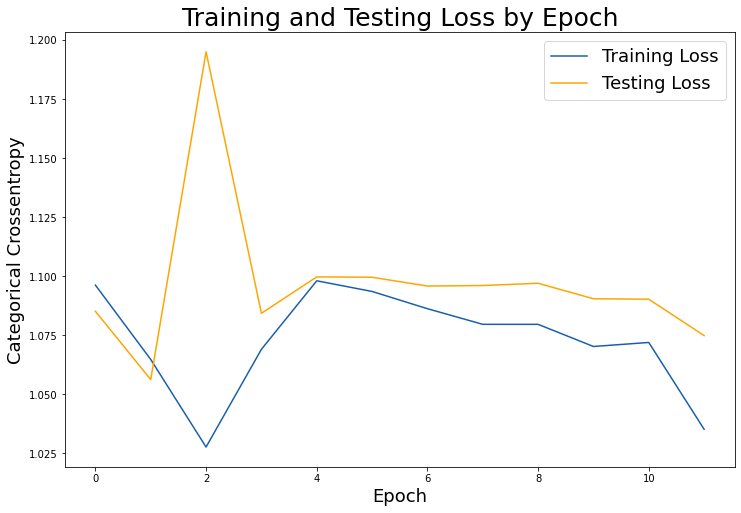

In [22]:
# plotting our models loss over epochs
train_loss = cnn_results.history['loss']
test_loss = cnn_results.history['val_loss']

# setting figure size
plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# setting title and labels
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)

# adding a legend
plt.legend(fontsize = 18);

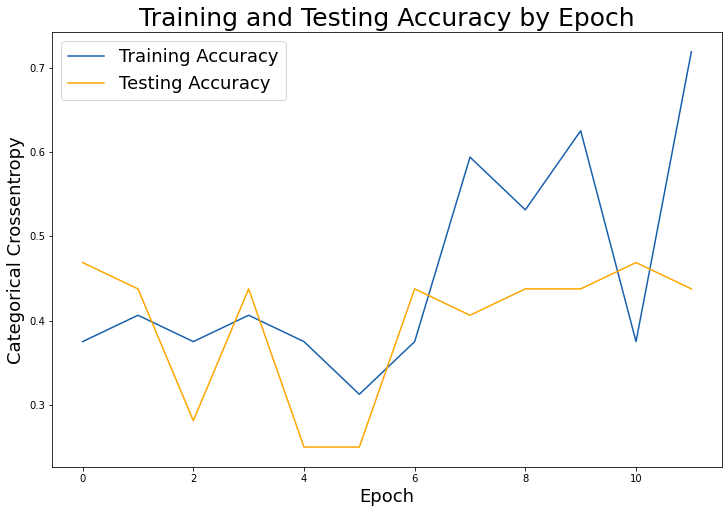

In [23]:
# plotting our models accuracy over epochs
train_acc = cnn_results.history['accuracy']
test_acc = cnn_results.history['val_accuracy']

# setting figure size
plt.figure(figsize=(12, 8))

plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# setting title and labels
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)

# adding a legend
plt.legend(fontsize = 18);

In [24]:
# evaluating model on test data

cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)

cnn_labels = cnn_model.metrics_names

# comparing CNN and FFNN models
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

1/1 [==============================] - 0s 337ms/step - loss: 1.0749 - accuracy: 0.4375
CNN loss  : 1.0748934745788574
CNN accuracy   : 0.4375

FFNN loss : 1.1989508867263794
FFNN accuracy  : 0.40625


Our CNN model improved our accuracy and reduced our loss significantly and with a smoother more reliable line to the output. We'll try this model on new data below.

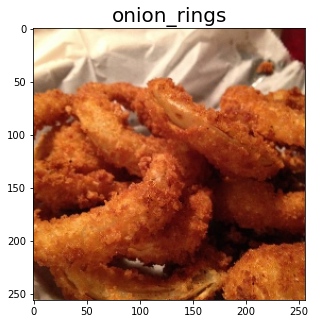

In [25]:
# visualizing one image prediction
# image path to one of our dataset's images
image_path="./part_01/food-11/images/bar_food/onion_rings/1008652.jpg"
# visualizing one prediction
plt.figure(figsize=(5,5))

# loading the image and preprocessing it for the model to predict it
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = cnn_model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

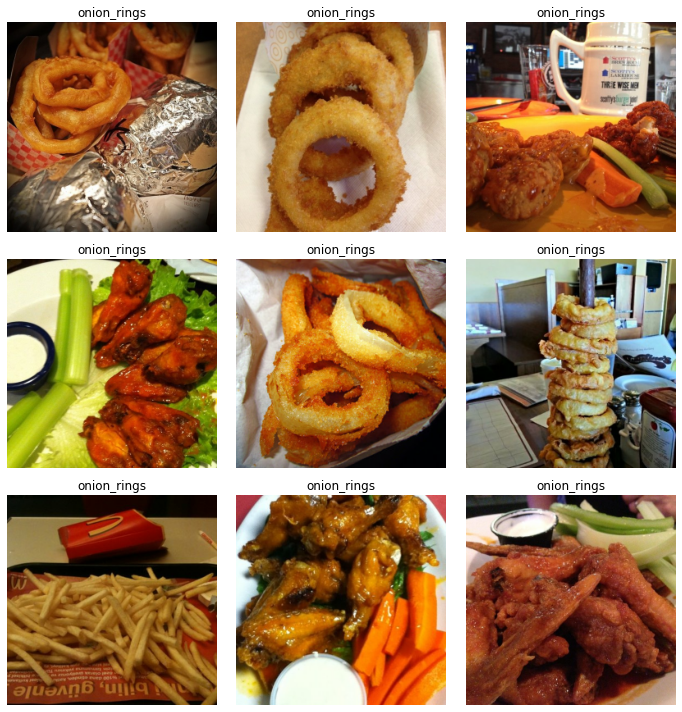

In [26]:
# visualizing a batch of images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(cnn_model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

In [27]:
# saving the model
cnn_model.save('CNN_barfood.h5')

In [28]:
## code from lesson 9.04
# making predictions on testing dataset
preds = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df = pd.DataFrame({
    'Label': preds,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df.to_csv('CNN_barfood_preds.csv', index=False)

### ** Interpretation **

The CNN model, with 2 convolutional layers and 5 dense layers and 2 dropout layers, performed much better than our feed-forward neural network. We achieved 100% accuracy with a very low loss for our training and testing data.

However, when we evaluate the model again on the testing data, we get 72% accuracy.